In [1]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols, glm
from urllib.parse import urlparse
import re
from urllib.parse import urlparse
import requests
from urllib.parse import urlparse
from bs4 import BeautifulSoup

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
workspace_path = '/gdrive/My Drive/Colab Notebooks/capstone/'

In [4]:
ph_df = pd.read_csv(os.path.join(workspace_path, 'phishing.csv'), sep=',', header=0, engine='python')
norm = pd.read_csv(os.path.join(workspace_path, 'normal.csv'), sep=',', header=0, engine='python', encoding='latin1')
norm1 = pd.read_csv(os.path.join(workspace_path, 'normal1.csv'), sep=',', header=0, engine='python')
norm2 = pd.read_csv(os.path.join(workspace_path, 'normal2.csv'), sep=',', header=0, engine='python', encoding='latin1')

In [5]:
norm1['url'] = 'https://' + norm1['url']

In [6]:
norm.head()

,url
0,https://www.mavia.com/
1,https://credinetweb.bcp.com.bo/#/login
2,https://login.live.com.office.ausunitypreprod....
3,https://login.live.com.office.ausunitypreprod....
4,http://login.live.com.office.urgo-prod1.labora...


In [7]:
norm1.head()

,url
0,https://google.com
1,https://youtube.com
2,https://facebook.com
3,https://baidu.com
4,https://wikipedia.org


In [8]:
norm2.head()

,url
0,http://socialdisasterscommission.go.kr/
1,http://www.bai.go.kr/mobile/index.do
2,http://www.bai.go.kr
3,http://www.bai.go.kr/child/index.do
4,http://www.pasa.go.kr


In [9]:
ph_df.head()

,url
0,https://kirpalthakur.com/ionos/
1,http://tinyurl.com/77drs68j
2,http://tinyurl.com/5n99993x
3,https://docs.google.com/presentation/d/e/2PACX...
4,https://docs.google.com/presentation/d/e/2PACX...


In [165]:
norm_df = pd.concat([norm1[:16000], norm2[:16000], norm[:23000]], ignore_index=True)

In [166]:
ph_df.shape

(55211, 1)

In [167]:
norm_df.shape

(55000, 1)

In [168]:
print(norm1.shape)
print(norm2.shape)

(1000000, 1)
(22341, 1)


In [169]:
# 피처 추출 함수
def extract_features(url):
    parsed_url = urlparse(url)
    domain = parsed_url.netloc  # 도메인 부분 추출

    features = {
        'contains_at': int('@' in url),
        'contains_dash': int('-' in url),
        'url_length': len(domain),  # 도메인 길이 계산
        'is_https': int(url.startswith('https://')),
        'digit_count': sum(c.isdigit() for c in domain),
        'double_slash': int(url.count('//') > 1),
        'is_shortened': int(any(shortener in url for shortener in ['bit.ly', 'goo.gl', 'tinyurl.com'])),
        'subdomain_count': domain.count('.') - 1 if domain.startswith('www.') else domain.count('.')
    }
    return features



def extract_features2(url):
    features = {}
    parsed_url = urlparse(url)

    # 1. 웹사이트 생성 날짜
    try:
        domain_info = whois.whois(parsed_url.netloc)
        features['creation_date'] = domain_info.creation_date
    except Exception:
        features['creation_date'] = None

    # 2. URL 내용이 소스코드 내에 포함
    try:
        response = requests.get(url, timeout=5)
        features['url_in_source'] = url in response.text
    except Exception:
        features['url_in_source'] = False

    # 3. 비표준 포트 사용
    port = parsed_url.port
    features['non_standard_port'] = port not in [None, 80, 443]

    # 4. HTML 소스코드 길이
    try:
        features['source_code_length'] = len(response.text)
    except Exception:
        features['source_code_length'] = None

    return features


# 데이터프레임에 피처 추출 적용 함수
def extract_features_from_dataframe(df):
    features_list = []
    for url in df['url']:
        features = extract_features(url)
        # features2 = extract_features2(url)
        # features.update(features2)
        features_list.append(features)

    features_df = pd.DataFrame(features_list)
    return features_df

In [170]:
# 피처 추출
ph_features_df = extract_features_from_dataframe(ph_df)
norm_features_df = extract_features_from_dataframe(norm_df)

In [171]:

# 피싱 및 정상 데이터셋에 레이블 추가
ph_features_df['label'] = 1  # 피싱 URL
norm_features_df['label'] = 0  # 정상 URL

In [172]:
# 데이터셋 병합
ph_val = ph_features_df.sample(n=5000, random_state=42)
ph_train = ph_features_df.drop(ph_val.index)

norm_val = norm_features_df.sample(n=5000, random_state=42)
norm_train = norm_features_df.drop(norm_val.index)

valset = pd.concat([ph_val, norm_val])
df = pd.concat([ph_train, norm_train], ignore_index=True)

In [173]:
df.head()

,contains_at,contains_dash,url_length,is_https,digit_count,double_slash,is_shortened,subdomain_count,label
0,0,0,16,1,0,0,0,1,1
1,0,0,11,0,0,0,1,1,1
2,0,0,11,0,0,0,1,1,1
3,0,1,15,1,0,0,0,2,1
4,0,0,16,1,0,0,0,2,1


In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100211 entries, 0 to 100210
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   contains_at      100211 non-null  int64
 1   contains_dash    100211 non-null  int64
 2   url_length       100211 non-null  int64
 3   is_https         100211 non-null  int64
 4   digit_count      100211 non-null  int64
 5   double_slash     100211 non-null  int64
 6   is_shortened     100211 non-null  int64
 7   subdomain_count  100211 non-null  int64
 8   label            100211 non-null  int64
dtypes: int64(9)
memory usage: 6.9 MB


In [175]:
df_corr = df.corr(method='pearson')
df_corr

,contains_at,contains_dash,url_length,is_https,digit_count,double_slash,is_shortened,subdomain_count,label
contains_at,1.000000,0.075933,0.042247,0.036843,0.074630,0.038759,-0.001489,-0.031246,0.039050
contains_dash,0.075933,1.000000,0.348458,0.211816,0.278027,0.065252,-0.054852,0.079816,0.347744
url_length,0.042247,0.348458,1.000000,0.124711,0.609876,0.001937,-0.071977,0.519831,0.380068
is_https,0.036843,0.211816,0.124711,1.000000,0.099688,-0.009594,-0.027677,-0.216561,0.352259
digit_count,0.074630,0.278027,0.609876,0.099688,1.000000,0.016454,-0.031195,0.276953,0.312730
double_slash,0.038759,0.065252,0.001937,-0.009594,0.016454,1.000000,-0.004320,0.084257,-0.025582
is_shortened,-0.001489,-0.054852,-0.071977,-0.027677,-0.031195,-0.004320,1.000000,-0.077142,0.013462
subdomain_count,-0.031246,0.079816,0.519831,-0.216561,0.276953,0.084257,-0.077142,1.000000,0.176110
label,0.039050,0.347744,0.380068,0.352259,0.312730,-0.025582,0.013462,0.176110,1.000000


In [176]:
df.label.value_counts() # doc 2021개, docx 2004개

1    50211
0    50000
Name: label, dtype: int64

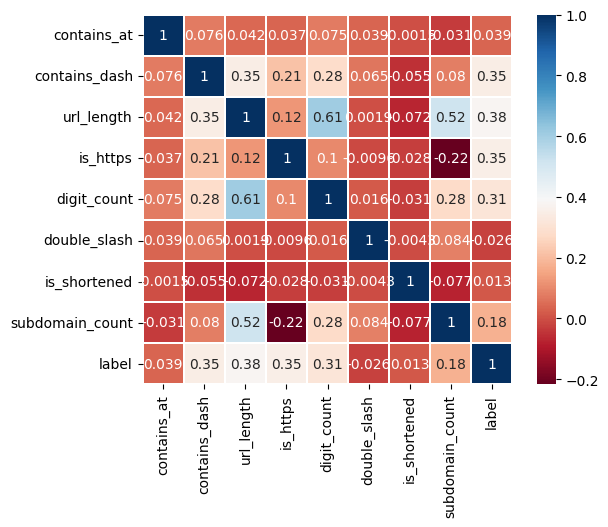

In [177]:
heatmap_data = df.select_dtypes(include=[np.number])
colormap = plt.cm.RdBu
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True,
            annot_kws={'size': 10})
plt.show()

In [249]:
# 데이터 준비 (독립 변수와 종속 변수 분리)
X = df.drop(columns=['label'])
y = df['label']
val_input = valset.drop(columns=['label'])
val_target = valset['label']

# 컬럼 이름 정제 (공백과 특수 문자를 언더스코어(_)로 변경)
val_input.columns = val_input.columns.str.replace('[^a-zA-Z0-9]', '_')
X.columns = X.columns.str.replace('[^a-zA-Z0-9]', '_')

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<ipython-input-249-155649ef768e>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  val_input.columns = val_input.columns.str.replace('[^a-zA-Z0-9]', '_')
<ipython-input-249-155649ef768e>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  X.columns = X.columns.str.replace('[^a-zA-Z0-9]', '_')


# LGBM 모델

In [250]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# LightGBM 데이터셋 생성
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# LightGBM 모델 설정 (나머지 코드는 이전과 동일)
params = {
    'objective': 'binary',  # 이진 분류 설정
    'metric': 'binary_error',  # 이진 분류 정확도 측정
    'boosting_type': 'rf',  # Gradient Boosting Decision Tree
    'num_leaves': 63,  # 과적합 방지를 위해 트리의 최대 잎 노드 수 줄임
    'learning_rate': 0.01,  # 과적합 방지를 위해 낮은 학습률 설정
    'feature_fraction': 0.9,  # 트리마다 무작위로 선택되는 피처 비율 줄임
    'bagging_fraction': 0.9,  # 각 반복마다 무작위로 선택되는 데이터 비율 줄임
    'bagging_freq': 5,  # 5번의 반복마다 배깅 수행
    'lambda_l1': 0.1,  # L1 정규화 적용
    'lambda_l2': 0.1,  # L2 정규화 적용
    'max_depth': 15  # 과적합 방지를 위해 트리의 최대 깊이 제한
}

In [251]:
# LightGBM 모델 학습
num_round = 20  # 트리 수 (조정 가능)
lgb_model = lgb.train(params, train_data, num_round)

[LightGBM] [Info] Number of positive: 40104, number of negative: 40064
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 131
[LightGBM] [Info] Number of data points in the train set: 80168, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500249 -> initscore=0.000998
[LightGBM] [Info] Start training from score 0.000998


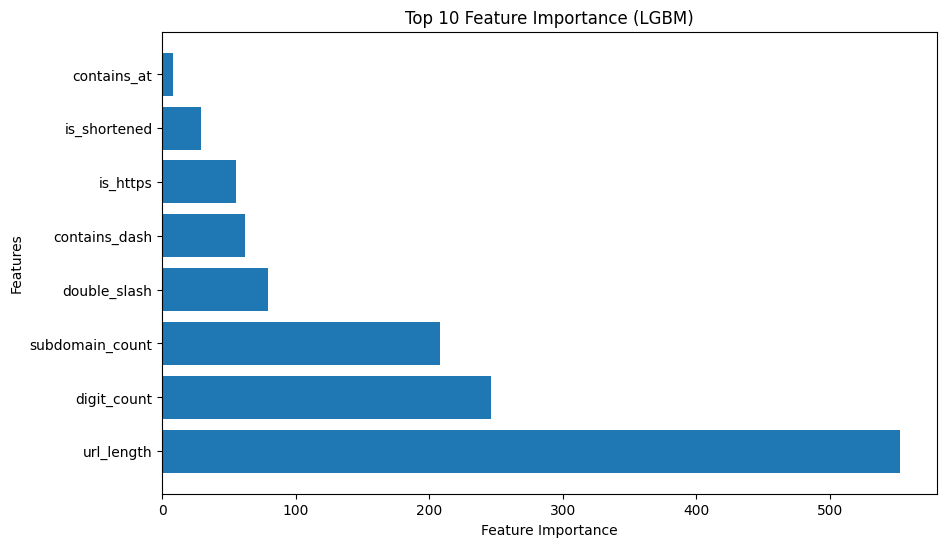

In [252]:
import matplotlib.pyplot as plt

# LightGBM 모델에서 피쳐 중요도 가져오기
feature_importance = lgb_model.feature_importance()
feature_names = X_train.columns

# 중요도를 피쳐 이름과 연결
feature_importance_dict = dict(zip(feature_names, feature_importance))

# 중요도를 기준으로 내림차순 정렬
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# 상위 N개의 피쳐만 선택 (예: 상위 10개)
top_n = 10
top_features = dict(sorted_feature_importance[:top_n])

# 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_features.values(), align='center')
plt.yticks(range(len(top_features)), top_features.keys())
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top {} Feature Importance (LGBM)'.format(top_n))
plt.show()


In [253]:
# 모델 예측
y_pred_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
y_pred_binary_lgb = [1 if pred > 0.5 else 0 for pred in y_pred_lgb]  # 이진 예측

In [254]:
# 정확도 출력
accuracy_lgb = accuracy_score(y_test, y_pred_binary_lgb)
print("Accuracy:", accuracy_lgb)

# 분류 보고서 출력
classification_rep_lgb = classification_report(y_test, y_pred_binary_lgb)
print("Classification Report:\n", classification_rep_lgb)

# 혼동 행렬 출력
conf_matrix_lgb = confusion_matrix(y_test, y_pred_binary_lgb)
print("Confusion Matrix:\n", conf_matrix_lgb)

Accuracy: 0.847976849772988
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85      9936
           1       0.88      0.80      0.84     10107

    accuracy                           0.85     20043
   macro avg       0.85      0.85      0.85     20043
weighted avg       0.85      0.85      0.85     20043

Confusion Matrix:
 [[8860 1076]
 [1971 8136]]


In [255]:
# 검증 데이터 예측
val_pred_lgb = lgb_model.predict(val_input, num_iteration=lgb_model.best_iteration)
val_pred_binary_lgb = [1 if pred > 0.5 else 0 for pred in val_pred_lgb]  # 이진 예측

In [256]:
# 정확도 출력
accuracy_val_lgb = accuracy_score(val_target, val_pred_binary_lgb)
print("Accuracy:", accuracy_val_lgb)

# 분류 보고서 출력
classification_val_lgb = classification_report(val_target, val_pred_binary_lgb)
print("Classification Report:\n", classification_val_lgb)

Accuracy: 0.846
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      5000
           1       0.87      0.81      0.84      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



# RandomForest

In [219]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 랜덤 포레스트 모델 생성 및 학습
rf_model = RandomForestClassifier(random_state=42,
                                   n_estimators=150,
                                   criterion='log_loss',
                                   n_jobs=2,

                                   )
rf_model.fit(X_train, y_train)

RandomForestClassifier(criterion='log_loss', n_estimators=150, n_jobs=2,
                       random_state=42)

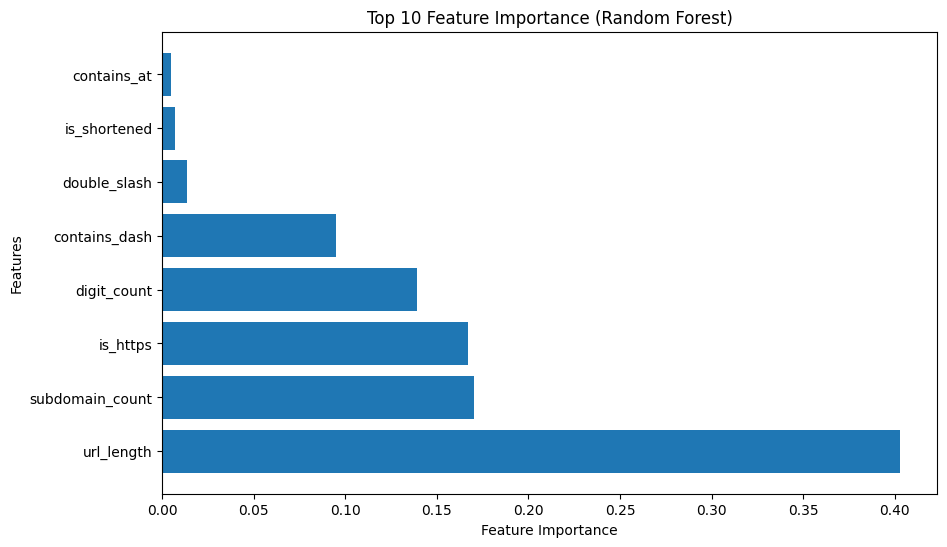

In [220]:
import matplotlib.pyplot as plt

# 학습된 Random Forest 모델에서 피처 중요도 가져오기
feature_importance = rf_model.feature_importances_

# 각 피처와 그 중요도를 연결
feature_names = X_train.columns
feature_importance_dict = dict(zip(feature_names, feature_importance))

# 중요도를 기준으로 내림차순 정렬
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# 상위 N개의 피처만 선택 (예: 상위 10개)
top_n = 10
top_features = dict(sorted_feature_importance[:top_n])

# 그래프로 시각화
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_features.values(), align='center')
plt.yticks(range(len(top_features)), top_features.keys())
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top {} Feature Importance (Random Forest)'.format(top_n))
plt.show()


In [230]:
# 모델 예측
y_pred_rf = rf_model.predict(X_test)

In [231]:
# 정확도 출력
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy_rf)

# 분류 보고서 출력
classification_rep_rf = classification_report(y_test, y_pred_rf)
print("Classification Report:\n", classification_rep_rf)

# 혼동 행렬 출력
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:\n", conf_matrix_rf)

Accuracy: 0.8597016414708377
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      9936
           1       0.89      0.82      0.86     10107

    accuracy                           0.86     20043
   macro avg       0.86      0.86      0.86     20043
weighted avg       0.86      0.86      0.86     20043

Confusion Matrix:
 [[8938  998]
 [1814 8293]]


In [233]:
# 모델 예측
val_pred_rf = rf_model.predict(val_input)

In [235]:
# 정확도 출력
accuracy_val_rf = accuracy_score(val_target, val_pred_rf)
print("Accuracy:", accuracy_val_rf)

# 분류 보고서 출력
classification_val_rf = classification_report(val_target, val_pred_rf)
print("Classification Report:\n", classification_val_rf)

# 혼동 행렬 출력
conf_matrix_val_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:\n", conf_matrix_val_rf)

Accuracy: 0.8581
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      5000
           1       0.88      0.82      0.85      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Confusion Matrix:
 [[8938  998]
 [1814 8293]]


# XGBOOST

In [236]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# XGBoost 데이터셋 생성
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# XGBoost 모델 설정
params = {
    'objective': 'binary:logistic',  # 이진 분류 설정
    'eval_metric': 'error',  # 이진 분류 오류율
    'booster': 'gbtree',  # 트리 기반 모델
    'max_depth': 10,  # 트리의 최대 깊이
    'eta': 0.005,  # 학습률
    'subsample': 0.8,  # 훈련 데이터의 하위 샘플 비율
}

In [237]:
# XGBoost 모델 학습
num_round = 20  # 부스팅 라운드 수 (조정 가능)
bst = xgb.train(params, dtrain, num_round)

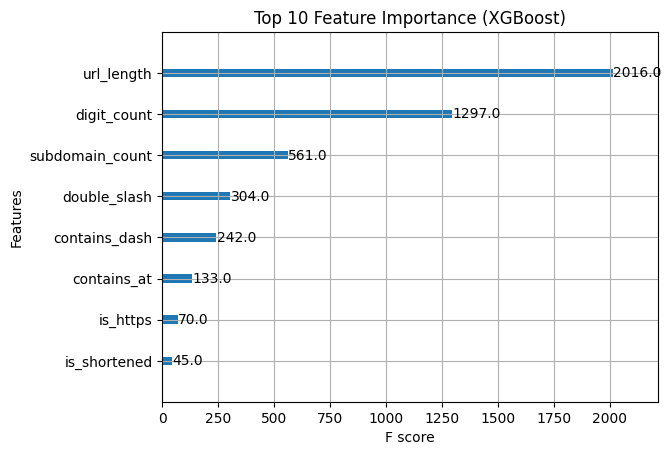

In [238]:
# 피쳐 중요도 가져오기 및 시각화
xgb.plot_importance(bst, max_num_features=10)
plt.title('Top 10 Feature Importance (XGBoost)')
plt.show()


In [239]:
# 모델 예측
y_pred_xgb = bst.predict(dtest)
y_pred_binary_xgb = [1 if pred > 0.5 else 0 for pred in y_pred_xgb]  # 이진 예측


In [240]:
# 정확도 출력
accuracy_xgb = accuracy_score(y_test, y_pred_binary_xgb)
print("Accuracy:", accuracy_xgb)


Accuracy: 0.8549119393304395


In [241]:
# 분류 보고서 출력
classification_rep_xgb = classification_report(y_test, y_pred_binary_xgb)
print("Classification Report:\n", classification_rep_xgb)

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      9936
           1       0.88      0.82      0.85     10107

    accuracy                           0.85     20043
   macro avg       0.86      0.86      0.85     20043
weighted avg       0.86      0.85      0.85     20043



In [242]:
# 혼동 행렬 출력
conf_matrix_xgb = confusion_matrix(y_test, y_pred_binary_xgb)
print("Confusion Matrix:\n", conf_matrix_xgb)

Confusion Matrix:
 [[8853 1083]
 [1825 8282]]


In [243]:
# 검증 데이터셋에 대한 예측
dval = xgb.DMatrix(val_input)
val_pred_xgb = bst.predict(dval)
val_pred_binary_xgb = [1 if pred > 0.5 else 0 for pred in val_pred_xgb]  # 이진 예측

# 정확도 출력
accuracy_val_xgb = accuracy_score(val_target, val_pred_binary_xgb)
print("Validation Accuracy:", accuracy_val_xgb)

# 분류 보고서 출력
classification_val_xgb = classification_report(val_target, val_pred_binary_xgb)  # val_pred6 대신 val_pred_binary 사용
print("Classification Report:\n", classification_val_xgb)

# 혼동 행렬 출력
conf_matrix_val_xgb = confusion_matrix(val_target, val_pred_binary_xgb)  # val_pred6 대신 val_pred_binary 사용
print("Confusion Matrix:\n", conf_matrix_val_xgb)

Validation Accuracy: 0.8526
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.86      5000
           1       0.87      0.82      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Confusion Matrix:
 [[4407  593]
 [ 881 4119]]


# 모델 비교평가

In [245]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 예측 결과와 실제 레이블
# 여기서 y_test는 실제 테스트 데이터 레이블이며, 각 모델의 예측 결과는 각각의 변수에 저장되어 있다고 가정
y_test = y_test
y_pred_lgbm = y_pred_binary_lgb
y_pred_rf = y_pred_rf
y_pred_xgb = y_pred_binary_xgb

# 각 모델의 성능 지표 계산
models = ['LightGBM', 'Random Forest', 'XGB']
y_preds = [y_pred_lgbm,  y_pred_rf,  y_pred_xgb]

for model, y_pred in zip(models, y_preds):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{model} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")


LightGBM - Accuracy: 0.85, Precision: 0.88, Recall: 0.80, F1 Score: 0.84
Random Forest - Accuracy: 0.86, Precision: 0.89, Recall: 0.82, F1 Score: 0.86
XGB - Accuracy: 0.85, Precision: 0.88, Recall: 0.82, F1 Score: 0.85


In [246]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 예측 결과와 실제 레이블
# 여기서 y_test는 실제 테스트 데이터 레이블이며, 각 모델의 예측 결과는 각각의 변수에 저장되어 있다고 가정
y_test = val_target
y_pred_lgbm = val_pred_binary_lgb
y_pred_rf = val_pred_rf
y_pred_xgb = val_pred_binary_xgb

# 각 모델의 성능 지표 계산
models = ['LightGBM',  'Random Forest', 'XGB']
y_preds = [y_pred_lgbm, y_pred_rf, y_pred_xgb]

for model, y_pred in zip(models, y_preds):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{model} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")


LightGBM - Accuracy: 0.85, Precision: 0.87, Recall: 0.81, F1 Score: 0.84
Random Forest - Accuracy: 0.86, Precision: 0.88, Recall: 0.82, F1 Score: 0.85
XGB - Accuracy: 0.85, Precision: 0.87, Recall: 0.82, F1 Score: 0.85
